# Evaluation of experiment 1: Delay length

Evaluates the results that come from one experiment

Experiments are based on the results that came from running

    experiments/experiment_1_delay_length/hpc_training.sh

## Experiment 1 Delay Length

In [1]:
# specify EXPERIMENT_NAME - has to correspond to experiments/EXPERIMENT_NAME and models/EXPERIMENT_NAME
experiment_name = "experiment_1_delay_length"

## Import packages and models

In [2]:
#change cwd but save path to notebook to save figures
import os
if not 'src' in os.listdir():
    base_dir_notebook = os.path.abspath(".")
    os.chdir("../..")
import pandas as pd
import yaml
import numpy as np
from src.models.utils import TrainedModels
from torch.utils.data import DataLoader
from src.data.synthetic_dataset import SyntheticDataset
import matplotlib.patches as patches
import pytorch_lightning as pl
import seaborn as sns
import matplotlib.pyplot as plt
from src.visualization.visualize import TrainValidationLossVisualization, Visualization, InferenceTimeVisualization
import optuna
from src.visualization.utils import FAU_BLUE, FAU_GREY, TURQUOIS

model_names = ["Transformer", "CNN", "LSTM"]
palette = [FAU_BLUE, FAU_GREY, TURQUOIS] # color palette for seaborn
palette_bp = [(98/256, 114/256, 136/256), FAU_GREY, TURQUOIS] # better color palette for boxplots

models_path = f"models/{experiment_name}"
test_dataset_path = f"./experiments/{experiment_name}/data/test.pkl"

trained_models = TrainedModels(models_path=models_path)

# figure path
if not os.path.exists(f"./experiments/{experiment_name}/figures"):
    os.makedirs(f"./experiments/{experiment_name}/figures")

2021-11-10 23:54:44 Mischa-PC src.models[8308] INFO Initializing Lightning model without test dataset
2021-11-10 23:54:44 Mischa-PC src.data[8308] INFO Loading dataset from ./experiments/experiment_1_delay_length/data/train.pkl
2021-11-10 23:54:44 Mischa-PC src.data[8308] INFO Loading dataset from ./experiments/experiment_1_delay_length/data/val.pkl
2021-11-10 23:54:44 Mischa-PC src.data[8308] INFO Shuffling dataset
2021-11-10 23:54:44 Mischa-PC src.data[8308] INFO Data augementation necessary for shuffling with batch size 128 and 9999 number of samples for each sequence length
2021-11-10 23:54:44 Mischa-PC src.data[8308] INFO Initializing and fitting new scaler to dataset
2021-11-10 23:54:44 Mischa-PC src.data[8308] INFO Using provided scaler to normalize dataset
2021-11-10 23:54:45 Mischa-PC src.models[8308] INFO Training size: 10112, Validation size: 1991
2021-11-10 23:54:45 Mischa-PC src.models[8308] INFO Transformer complexity: 1073741824
2021-11-10 23:54:45 Mischa-PC src.models[8

In [3]:
print([x["path"] for x in trained_models])

['/experiments/experiment_1_delay_length/data/train.pkl-epoch=97-val_loss=0.0373.ckpt', '/experiments/experiment_1_delay_length/data/train.pkl-epoch=56-val_loss=0.0527.ckpt', '/experiments/experiment_1_delay_length/data/train.pkl-epoch=99-val_loss=0.0421.ckpt']


# Visualize train/validation loss

2021-11-10 23:54:46 Mischa-PC src.visualization[8308] INFO using latex font


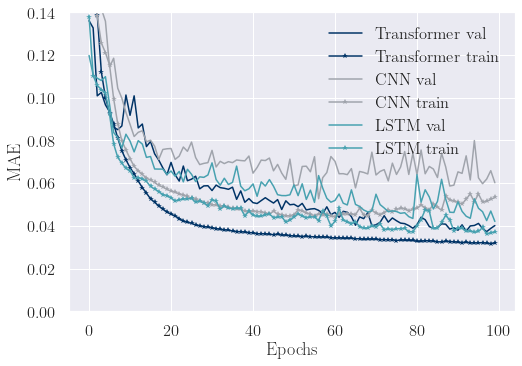

In [4]:
#load val/train loss
epoch = []
values = []
for model in trained_models:
    epoch.append(np.arange(len(model["val_loss"])))
    epoch.append(np.arange(len(model["train_loss"])))
    values.append(model["val_loss"])
    values.append(model["train_loss"])

# prepare style of plot
linestyle = ["-", "-","-", "-","-", "-",]
labels = ["Transformer val", "Transformer train", "CNN val", "CNN train", "LSTM val", "LSTM train"]
markers = ["", "*", "", "*", "", "*"]

# plot train and validaton loss and save figure
viz = TrainValidationLossVisualization(use_latex_font=True, font_scale=1.5)
viz.subplots(1, 1)
viz.plot(steps=epoch, val_losses=values, labels=labels, linestyles=linestyle, markers=markers, xlabel="Epochs", ylabel="MAE")
plt.legend()
plt.grid()
plt.ylim(0, 0.14)
plt.savefig(f"{base_dir_notebook}/figures/train_and_val_loss_all_models.pdf")
plt.show()

# Plot only Validation Loss

2021-11-10 23:54:51 Mischa-PC src.visualization[8308] INFO using latex font


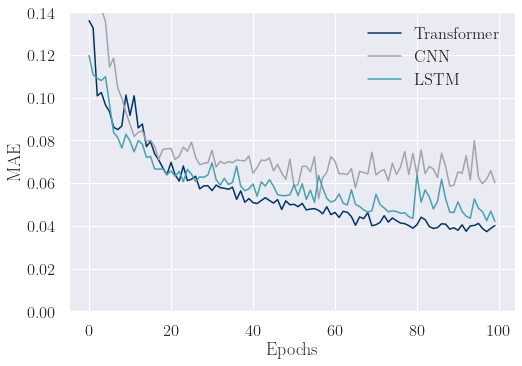

In [5]:
epoch = []
values = []
for model in trained_models:
    epoch.append(np.arange(len(model["val_loss"])))
    values.append(model["val_loss"])

linestyle = ["-","-","-"]
labels = ["Transformer", "CNN", "LSTM"]
markers = ["", "", ""]
colors = [FAU_BLUE, FAU_GREY, TURQUOIS]

# plot train and validaton loss and save figure
viz = TrainValidationLossVisualization(use_latex_font=True, font_scale=1.5)
viz.subplots(1, 1)
viz.plot(steps=epoch, val_losses=values, labels=labels, linestyles=linestyle, markers=markers, colors=colors, xlabel="Epochs", ylabel="MAE")
plt.legend()
plt.grid()
plt.ylim(0, 0.14)
plt.savefig(f"{base_dir_notebook}/figures/validation_loss_all_models.pdf")
plt.show()

## Save the performance of every model on every test sample seperately
First load data, normalized i based on training data and then perform test

In [6]:
test_dataloader = DataLoader(SyntheticDataset.load(test_dataset_path),
                                 batch_size=128)
if not test_dataloader.dataset.is_normalized:
    test_dataloader.dataset.normalize(scaler=trained_models["transformer"]["model"].train_dataset.scaler)

2021-11-10 23:54:52 Mischa-PC src.data[8308] INFO Loading dataset from ./experiments/experiment_1_delay_length/data/test.pkl
2021-11-10 23:54:52 Mischa-PC src.data[8308] INFO Using provided scaler to normalize dataset


## Transformer

In [7]:
tf_trainer = pl.Trainer(gpus=1, logger=None)
tf_trainer.test(model=trained_models["transformer"]["model"], test_dataloaders=test_dataloader)
transformer_predictions = pd.DataFrame(tf_trainer.lightning_module.evaluated_samples)

2021-11-10 23:54:52 Mischa-PC pytorch_lightning.utilities.distributed[8308] INFO GPU available: True, used: True
2021-11-10 23:54:52 Mischa-PC pytorch_lightning.utilities.distributed[8308] INFO TPU available: False, using: 0 TPU cores
2021-11-10 23:54:52 Mischa-PC pytorch_lightning.utilities.distributed[8308] INFO IPU available: False, using: 0 IPUs
C:\Users\Mischa\Anaconda3\envs\mtenv\lib\site-packages\pytorch_lightning\trainer\trainer.py:678: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
2021-11-10 23:54:52 Mischa-PC pytorch_lightning.accelerators.gpu[8308] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Mischa\Anaconda3\envs\mtenv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers`

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_mae': 0.040382515639066696, 'test_mse': 0.004349127411842346}
--------------------------------------------------------------------------------


## CNN

In [8]:
# Cnn traininer
cnn_trainer = pl.Trainer(gpus=1, logger=None)
cnn_trainer.test(model=trained_models["cnn"]["model"], test_dataloaders=test_dataloader)
cnn_predictions = pd.DataFrame(cnn_trainer.lightning_module.evaluated_samples)

2021-11-10 23:54:54 Mischa-PC pytorch_lightning.utilities.distributed[8308] INFO GPU available: True, used: True
2021-11-10 23:54:54 Mischa-PC pytorch_lightning.utilities.distributed[8308] INFO TPU available: False, using: 0 TPU cores
2021-11-10 23:54:54 Mischa-PC pytorch_lightning.utilities.distributed[8308] INFO IPU available: False, using: 0 IPUs
2021-11-10 23:54:54 Mischa-PC pytorch_lightning.accelerators.gpu[8308] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_mae': 0.05396655946969986, 'test_mse': 0.005420116242021322}
--------------------------------------------------------------------------------


## LSTM

In [9]:
# LSTM traininer
lstm_trainer = pl.Trainer(gpus=1, logger=None)
lstm_trainer.test(model=trained_models["lstm"]["model"], test_dataloaders=test_dataloader)
lstm_predictions = pd.DataFrame(lstm_trainer.lightning_module.evaluated_samples)

2021-11-10 23:54:56 Mischa-PC pytorch_lightning.utilities.distributed[8308] INFO GPU available: True, used: True
2021-11-10 23:54:56 Mischa-PC pytorch_lightning.utilities.distributed[8308] INFO TPU available: False, using: 0 TPU cores
2021-11-10 23:54:56 Mischa-PC pytorch_lightning.utilities.distributed[8308] INFO IPU available: False, using: 0 IPUs
2021-11-10 23:54:56 Mischa-PC pytorch_lightning.accelerators.gpu[8308] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

C:\Users\Mischa\Anaconda3\envs\mtenv\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_mae': 0.04315900430083275, 'test_mse': 0.0047290208749473095}
--------------------------------------------------------------------------------


## Mean Estimator baseline
Mae of estimator that uses mean of input as output prediction:

In [10]:
from torch.nn import L1Loss
loss = L1Loss()

mae = 0
count = 0
for x, y, chars in trained_models["transformer"]["model"].val_dataset: #test_dataloader: #
    # reshape s.t. shape == (batch_num, sample_sequence_length //2)
    y = y.transpose(0, 1) if len(y.shape) == 2 else y.reshape(-1, y.shape[1])
    x = x.transpose(0, 1) if len(x.shape) == 2 else x.reshape(-1, x.shape[1])
    means = x.mean(axis=(1)).reshape(y.shape[0], 1)
    preds = means.tile((1, y.shape[1] ))
    mae += loss(preds, y)
    count += 1
mean_predictor_mae= mae/count
print(mean_predictor_mae)

tensor(0.1137)


## Visualizations

### Start off by creating a dataframe with all the Predictions

In [11]:
transformer_predictions["model"] = "Transformer"
transformer_predictions["sample_idx"] = np.arange(len(transformer_predictions))

cnn_predictions["model"] = "CNN"
cnn_predictions["sample_idx"] = np.arange(len(cnn_predictions))

lstm_predictions["model"] = "LSTM"
lstm_predictions["sample_idx"] = np.arange(len(lstm_predictions))

frames = [transformer_predictions, cnn_predictions, lstm_predictions]
predictions = pd.concat(frames)
predictions.head()

,d,l,s,f,a1,a2,a3,mean,mae,mse,model,sample_idx
0,0.0,512.0,2.0,0.03125,-52.0,-49.0,-31.0,50,0.033204,0.001868,Transformer,0
1,0.0,512.0,2.0,0.03125,15.0,-3.0,22.0,54,0.011139,0.000189,Transformer,1
2,0.0,512.0,2.0,0.03125,-59.0,3.0,17.0,73,0.029273,0.001477,Transformer,2
3,0.0,512.0,2.0,0.03125,32.0,54.0,-14.0,76,0.026494,0.001040,Transformer,3
4,0.0,512.0,2.0,0.03125,-33.0,38.0,53.0,89,0.043225,0.002330,Transformer,4


# Visualize distribution of mae for different delay lengths

2021-11-10 23:54:58 Mischa-PC src.visualization[8308] INFO using latex font


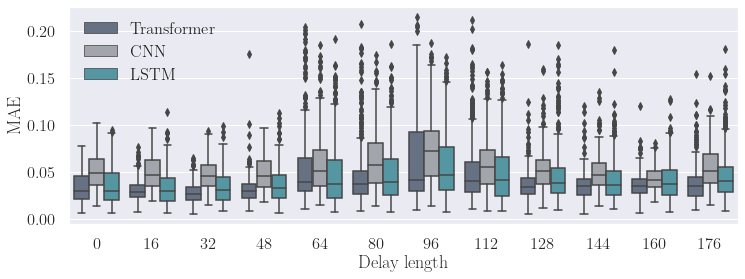

In [12]:
viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axs = viz.subplots(1, 1, figsize=(12, 4))
#palette = [FAU_BLUE, ]
sns.boxplot(x="d", y="mae", hue="model", data=predictions, palette=palette_bp)
plt.ylabel("MAE")
delays = predictions["d"].unique()
plt.xticks(ticks=np.arange(len(delays)), labels=[int(x) for x in delays])
plt.xlabel("Delay length")
plt.legend().title = None # disables legend title which is 'model'
plt.savefig(base_dir_notebook + "/figures/mae_different_delays_boxplot.pdf", bbox_inches="tight")

# Visualize distribution of mae for different frequencies
(Not so interesting for only one frequency, but done to make different notebooks more consistent

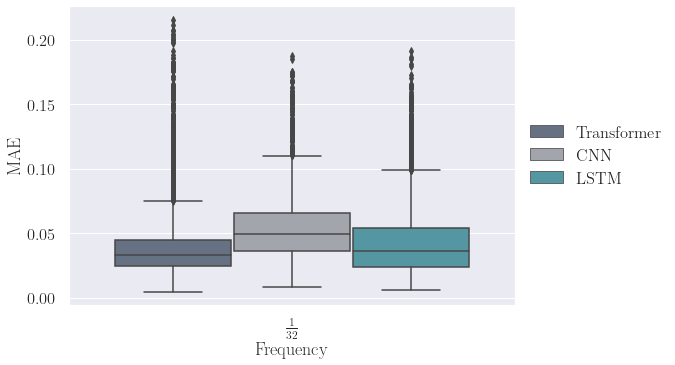

In [13]:
sns.boxplot(x="f", y="mae", hue="model", data=predictions, palette=palette_bp)
plt.ylabel("MAE")
freqs = predictions["f"].unique()
nice_labels = {1/128:r"$\frac{1}{128}$", 1/64:r"$\frac{1}{64}$", 1/32:r"$\frac{1}{32}$", 1/16:r"$\frac{1}{16}$", 1/8:r"$\frac{1}{8}$"}
plt.xticks(ticks=np.arange(len(freqs)), labels=[nice_labels[f] for f in freqs])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
plt.xlabel("Frequency")
plt.savefig(base_dir_notebook + "/figures/mae_different_frequencies.pdf")

# Visualize distribution of mae for different sigmas

2021-11-10 23:55:02 Mischa-PC src.visualization[8308] INFO using latex font


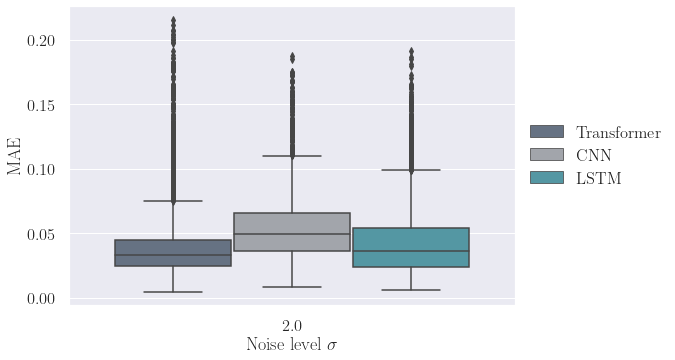

In [14]:
from src.visualization.visualize import Visualization
viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axs = viz.subplots(1, 1)
sns.boxplot(x="s", y="mae", hue="model", data=predictions, palette=palette_bp)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
plt.ylabel("MAE")
plt.xlabel("Noise level $\sigma$")
plt.savefig(base_dir_notebook + "/figures/mae_different_noise_levels.pdf", )

# Visualize distribution of mae for different sequence lengths

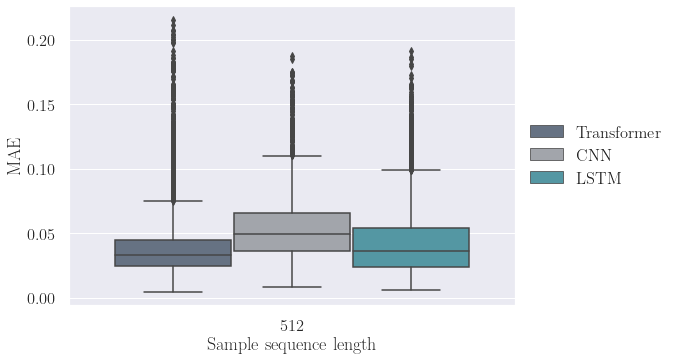

In [15]:
sns.boxplot(x="l", y="mae", hue="model", data=predictions, palette=palette_bp)
plt.ylabel("MAE")
seq_lens = predictions["l"].unique()
plt.xticks(ticks=np.arange(len(seq_lens)), labels=[int(x) for x in seq_lens])
plt.xlabel("Sample sequence length")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
plt.savefig(base_dir_notebook + "/figures/mae_different_seqlens.pdf")

# Visualize distribution of MAEs for different Delay Lengths

## Same visualization but this time with median and statistical

2021-11-10 23:55:03 Mischa-PC src.visualization[8308] INFO using latex font


Transformer:
f:   0 lower: 0.027 - median: 0.029 - upper: 0.032
f:  16 lower: 0.027 - median: 0.028 - upper: 0.030
f:  32 lower: 0.026 - median: 0.027 - upper: 0.028
f:  48 lower: 0.028 - median: 0.029 - upper: 0.031
f:  64 lower: 0.038 - median: 0.039 - upper: 0.042
f:  80 lower: 0.035 - median: 0.037 - upper: 0.039
f:  96 lower: 0.039 - median: 0.041 - upper: 0.047
f: 112 lower: 0.037 - median: 0.040 - upper: 0.042
f: 128 lower: 0.032 - median: 0.034 - upper: 0.036
f: 144 lower: 0.033 - median: 0.035 - upper: 0.036
f: 160 lower: 0.033 - median: 0.035 - upper: 0.037
f: 176 lower: 0.034 - median: 0.035 - upper: 0.036
CNN:
f:   0 lower: 0.046 - median: 0.049 - upper: 0.051
f:  16 lower: 0.044 - median: 0.047 - upper: 0.050
f:  32 lower: 0.043 - median: 0.046 - upper: 0.047
f:  48 lower: 0.042 - median: 0.046 - upper: 0.049
f:  64 lower: 0.047 - median: 0.051 - upper: 0.054
f:  80 lower: 0.052 - median: 0.057 - upper: 0.062
f:  96 lower: 0.065 - median: 0.072 - upper: 0.076
f: 112 lower:

<Figure size 576x396 with 0 Axes>

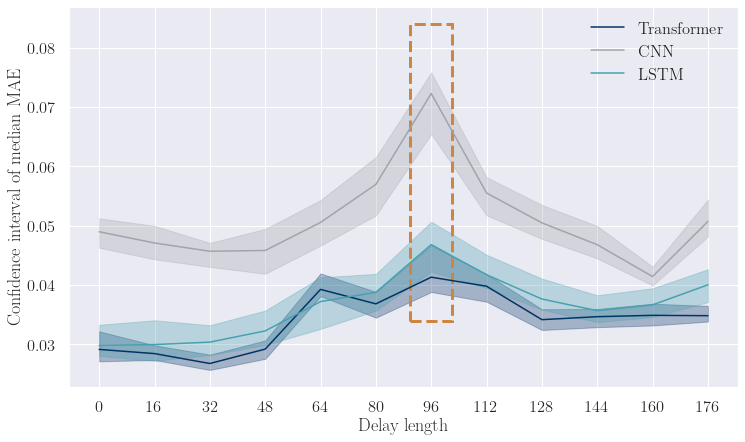

In [16]:
from src.visualization.visualize import ConfidenceIntervalVisualization

plt.clf()
viz = ConfidenceIntervalVisualization(use_latex_font=True, font_scale=1.5)
viz.subplots(1, 1, figsize=(12, 7))
viz.plot(predictions=predictions, characteristic="d", xlabel="Delay length", ylabel="Confidence interval of median MAE", colors=palette, verbose=True, plot_only_median=False)
plt.legend()
xticks = predictions["d"].unique()
rect = patches.Rectangle((90, 0.034), 12, 0.05, linewidth=3, edgecolor="peru", linestyle="--", facecolor='none')
viz.get_ax(0).add_patch(rect)
plt.xticks(xticks, labels=[int(xt) for xt in xticks])
plt.savefig(base_dir_notebook + "/figures/confidence_intervals_delays.pdf")
plt.show()


## Bin amplitudes into categories to visualize performance change of different amplitudes

In [17]:
bin_boundaries = np.linspace(-60, 60, 13)
bins = np.linspace(-55, 55, 12)
for i in range(len(bin_boundaries) - 1):
    predictions.loc[(predictions["a1"] >= bin_boundaries[i]) & (predictions["a1"] < bin_boundaries[i + 1]), "a1_bin"] = bins[i]
    predictions.loc[(predictions["a2"] >= bin_boundaries[i]) & (predictions["a2"] < bin_boundaries[i + 1]), "a2_bin"] = bins[i]
predictions.loc[predictions["a1"] == 60, "a1_bin"] = bins[-1]
predictions.loc[predictions["a2"] == 60, "a2_bin"] = bins[-1]

## Visualize binned amplitudes

2021-11-10 23:55:03 Mischa-PC src.visualization[8308] INFO using latex font


Transformer:
f: -55 lower: 0.037 - median: 0.045 - upper: 0.056
f: -45 lower: 0.028 - median: 0.033 - upper: 0.045
f: -35 lower: 0.028 - median: 0.031 - upper: 0.037
f: -25 lower: 0.034 - median: 0.039 - upper: 0.043
f: -15 lower: 0.032 - median: 0.033 - upper: 0.039
f:  -5 lower: 0.031 - median: 0.034 - upper: 0.044
f:   5 lower: 0.025 - median: 0.031 - upper: 0.042
f:  15 lower: 0.025 - median: 0.029 - upper: 0.048
f:  25 lower: 0.028 - median: 0.033 - upper: 0.039
f:  35 lower: 0.027 - median: 0.033 - upper: 0.039
f:  45 lower: 0.029 - median: 0.033 - upper: 0.037
f:  55 lower: 0.029 - median: 0.031 - upper: 0.032
CNN:
f: -55 lower: 0.053 - median: 0.065 - upper: 0.084
f: -45 lower: 0.053 - median: 0.059 - upper: 0.082
f: -35 lower: 0.055 - median: 0.060 - upper: 0.073
f: -25 lower: 0.066 - median: 0.070 - upper: 0.078
f: -15 lower: 0.061 - median: 0.073 - upper: 0.085
f:  -5 lower: 0.065 - median: 0.080 - upper: 0.088
f:   5 lower: 0.063 - median: 0.072 - upper: 0.077
f:  15 lower:

<Figure size 576x396 with 0 Axes>

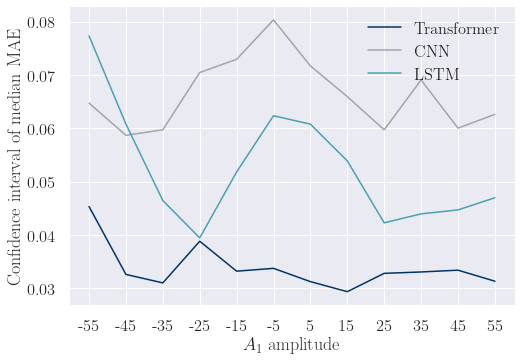

In [18]:
from src.visualization.visualize import ConfidenceIntervalVisualization

plt.clf()
viz = ConfidenceIntervalVisualization(use_latex_font=True, font_scale=1.5)
viz.subplots(1, 1)
filtered_predictions = predictions[predictions["a2_bin"] == -55]
viz.plot(predictions=filtered_predictions, characteristic="a1_bin", xlabel="$A_1$ amplitude", ylabel="Confidence interval of median MAE", colors=palette, verbose=True, plot_only_median=True)
plt.legend()
xticks = filtered_predictions["a1_bin"].unique()
plt.xticks(xticks, labels=[int(xt) for xt in xticks])
plt.savefig(base_dir_notebook + "/figures/confidence_intervals_ampltidues_a2_minus55.pdf")
plt.show()


# Visualize distribution of amplitude

2021-11-10 23:55:04 Mischa-PC src.visualization[8308] INFO using latex font


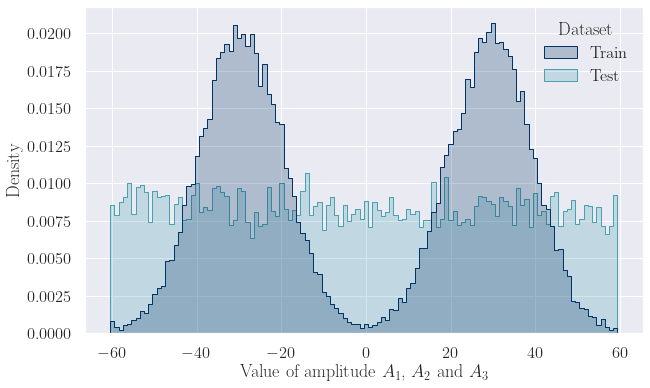

In [19]:
#load amplitudes a1, a2 and a3 from train dataset, and count appearances
train_amplitudes = trained_models["transformer"]["model"].train_dataset._amplitudes[:,:3].reshape(-1) # same as model cnn and lstm
test_amplitudes = test_dataloader.dataset._amplitudes[:,:3].reshape(-1)
# save what dataset the amplitude came from
dataset_indicator = np.zeros(len(train_amplitudes) + len(test_amplitudes))
dataset_indicator[len(train_amplitudes):] = 1
amplitude_df = pd.DataFrame({'amplitude':np.concatenate((train_amplitudes, test_amplitudes)), 'Dataset': ["Train"] * len(train_amplitudes) + ["Test"]* len(test_amplitudes)})
bins=np.arange(train_amplitudes.min(), train_amplitudes.max()+1)-0.5

viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axs = viz.subplots(1, 1, figsize=(10, 6))
sns.histplot(ax=axs[0, 0], data=amplitude_df, x="amplitude", hue="Dataset", palette=[palette[0], palette[2]], bins=bins, element='step', stat="density", common_norm=False)
plt.xlabel("Value of amplitude $A_1$, $A_2$ and $A_3$")
plt.legend
plt.savefig(base_dir_notebook + "/figures/train_test_data_distribution.pdf")
plt.show()


# Visualize Difference of model performance depending on the Delay Length

2021-11-10 23:55:06 Mischa-PC src.visualization[8308] INFO using latex font


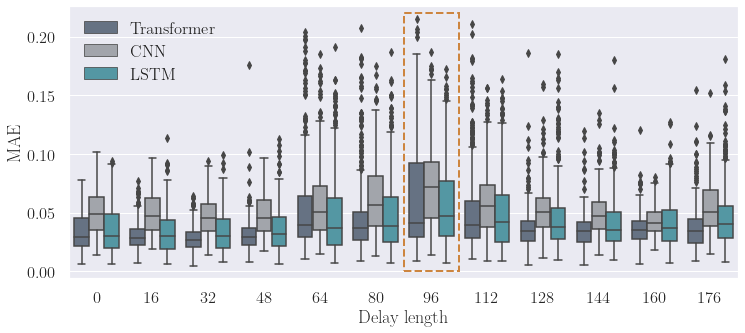

In [20]:
viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axs = viz.subplots(1, 1, figsize=(12, 5))
sns.boxplot(x="d", y="mae", hue="model", data=predictions, palette=palette_bp)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
plt.legend()
plt.ylabel("MAE")
plt.xlabel("Delay length")
rect = patches.Rectangle((5.5, 0), 1, 0.22, linewidth=2, edgecolor="peru", linestyle="--", facecolor='none')
plt.xticks(ticks=np.arange(len(delays)), labels=[int(x) for x in delays])
viz.get_ax(0).add_patch(rect)
plt.savefig(base_dir_notebook + "/figures/mae_different_delays_all_models.pdf", bbox_inches="tight")


## Visualize the accuracy depending on the amplitude
a2 fixed to -55 bin

2021-11-10 23:55:08 Mischa-PC src.visualization[8308] INFO using latex font


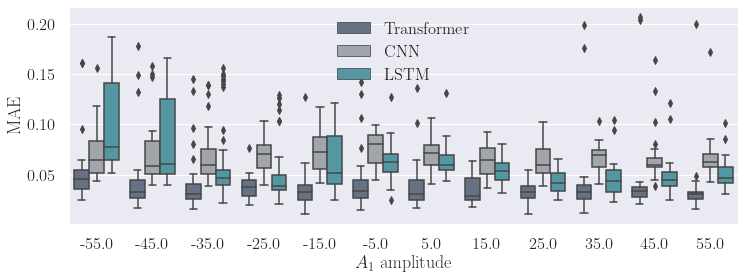

In [21]:
viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axs = viz.subplots(1, 1, figsize=(12, 4))
sns.boxplot(x="a1_bin", y="mae", hue="model", data=predictions[predictions["a2_bin"] == -55], palette=palette_bp)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
plt.legend()
plt.ylabel("MAE")
plt.xlabel("$A_1$ amplitude")
plt.savefig(base_dir_notebook + "/figures/mae_different_a1_bins_a2_bin_minus55.pdf", bbox_inches="tight")


## Visualize mean in 2d depending on the amplitudes

In [22]:
a1_bins = sorted(predictions["a1_bin"].unique())
a2_bins = sorted(predictions["a2_bin"].unique())

# save mean performance of each model and each amplitude combination seperately
means_trafo = np.zeros((len(a1_bins), len(a2_bins)))
means_cnn = np.zeros((len(a1_bins), len(a2_bins)))
means_lstm = np.zeros((len(a1_bins), len(a2_bins)))
for i, a1 in enumerate(a1_bins):
    for j, a2 in enumerate(a2_bins):
        means_trafo[i, j] = predictions[(predictions["a1_bin"] == a1) & (predictions["a2_bin"] == a2) & (predictions["model"] == "Transformer")]["mae"].mean()
        means_cnn[i, j] = predictions[(predictions["a1_bin"] == a1) & (predictions["a2_bin"] == a2) & (predictions["model"] == "CNN")]["mae"].mean()
        means_lstm[i, j] = predictions[(predictions["a1_bin"] == a1) & (predictions["a2_bin"] == a2) & (predictions["model"] == "LSTM")]["mae"].mean()

# save min max for colorbar normalization
means_min = min(means_trafo.min(), means_lstm.min(), means_cnn.min())
means_max = min(means_trafo.max(), means_lstm.max(), means_cnn.max())

2021-11-10 23:55:11 Mischa-PC src.visualization[8308] INFO using latex font


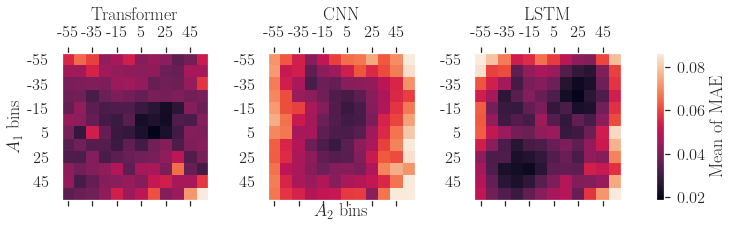

In [23]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
#https://stackoverflow.com/questions/13784201/how-to-have-one-colorbar-for-all-subplots
viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axes = viz.subplots(1, 3, figsize=(11,  3))
fig.tight_layout(pad=1.0)
normalizer=Normalize(means_min, means_max)
im=cm.ScalarMappable(norm=normalizer)
ims = []
for i, means in enumerate([means_trafo, means_cnn, means_lstm]):
    ax = viz.get_ax(i)
    ims.append(ax.matshow(means, norm=normalizer))
    ax.grid(False)
    ax.set_title(model_names[i])
    ax.set_xticks(np.arange(len(a2_bins))[::2])
    ax.set_yticks(np.arange(len(a1_bins))[::2])
    ax.set_xticklabels(np.array(a2_bins, dtype=int)[::2])
    ax.set_yticklabels(np.array(a1_bins, dtype=int)[::2])

viz.get_ax(0).set_ylabel("$A_1$ bins")
viz.get_ax(1).set_xlabel("$A_2$ bins")

fig.colorbar(im, ax=axes.ravel().tolist(), label="Mean of MAE")
#fig.colorbar().set_label()
plt.savefig(base_dir_notebook + "/figures/mae_amplitudes_all_models_matshow.pdf", bbox_inches="tight")
plt.show()


# Look at some of the best / worst predictions

## Start with worst predictions

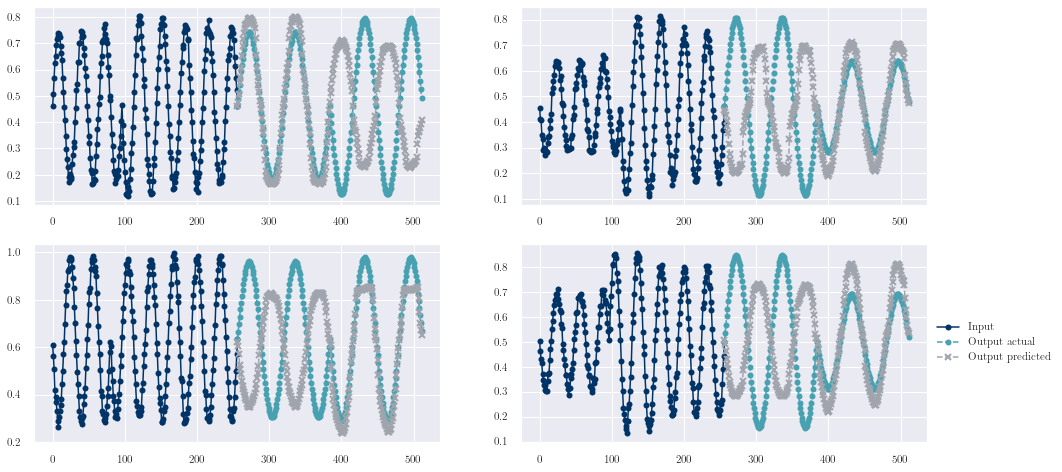

In [24]:
from src.visualization.visualize import ModelPredictionVisualization
transformer_outputs = np.array(tf_trainer.lightning_module.output_predictions)
cnn_outputs = np.array(cnn_trainer.lightning_module.output_predictions)
lstm_outputs  = np.array(lstm_trainer.lightning_module.output_predictions)
outputs = {"CNN": cnn_outputs,
           "Transformer": transformer_outputs,
           "LSTM":lstm_outputs}


viz_num = 4
# get the worst samples with delay length 48 and visualize them
samples = predictions.sort_values(by="mae")

best_samples = samples[:viz_num]
median_samples = samples[(len(samples) // 2):(len(samples) // 2 + viz_num)]
worst_samples = samples[-viz_num:]

# ground truth
worst_x, worst_y, _ = test_dataloader.dataset[worst_samples["sample_idx"]]
median_x, median_y, _ = test_dataloader.dataset[median_samples["sample_idx"]]
best_x, best_y, _ = test_dataloader.dataset[best_samples["sample_idx"]]

# predicted
out_preds = []
pred_start = len(worst_x[0])
for idx, model in zip(worst_samples["sample_idx"], worst_samples["model"]):
    out_preds.append(outputs[model][idx])

# Visualize
use_latex_font = False
viz = ModelPredictionVisualization(use_latex_font=False)
viz.subplots(nrows=viz_num // 2, ncols=2, figsize=(16, 8))
viz.plot(worst_x, worst_y, out_preds, pred_starts=[pred_start, ] * viz_num)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
viz.save(filename=base_dir_notebook+ "/figures/worst_samples.pdf")
viz.plt.show()

# Median Predictions

           mae model      d      l    s        f    a1    a2
695   0.039120  LSTM   32.0  512.0  2.0  0.03125  38.0  58.0
832   0.039122   CNN   32.0  512.0  2.0  0.03125  49.0   0.0
2646  0.039134  LSTM  112.0  512.0  2.0  0.03125  15.0  30.0
430   0.039135   CNN   16.0  512.0  2.0  0.03125 -37.0 -49.0


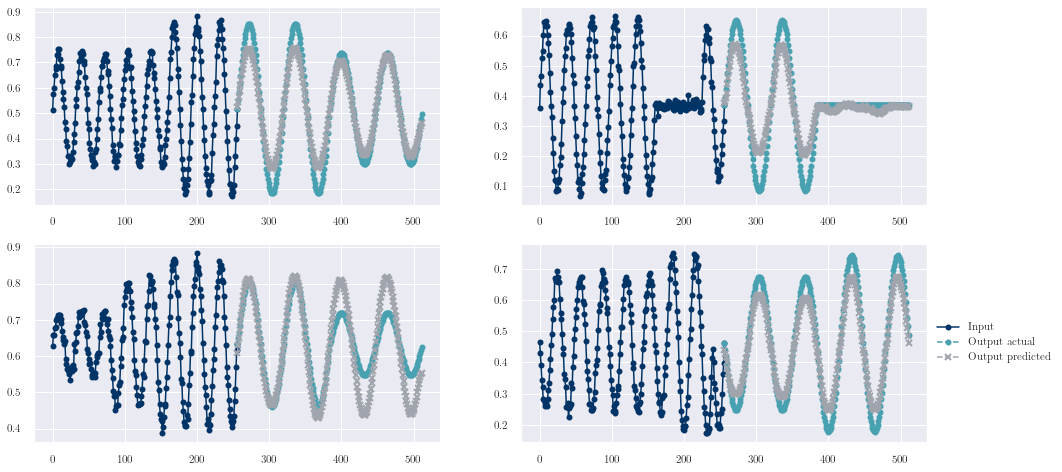

In [25]:
out_preds = []
print(median_samples[["mae", "model", "d","l","s","f","a1","a2"]])
for idx, model in zip(median_samples["sample_idx"], median_samples["model"]):
    out_preds.append(outputs[model][idx])

# Visualize
use_latex_font = False
viz = ModelPredictionVisualization(use_latex_font=False)
viz.subplots(nrows=viz_num // 2, ncols=2, figsize=(16, 8))
viz.plot(median_x, median_y, out_preds, pred_starts=[pred_start, ] * viz_num)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
viz.save(filename=base_dir_notebook+ "/figures/median_samples.pdf")
viz.plt.show()

## Best predictions

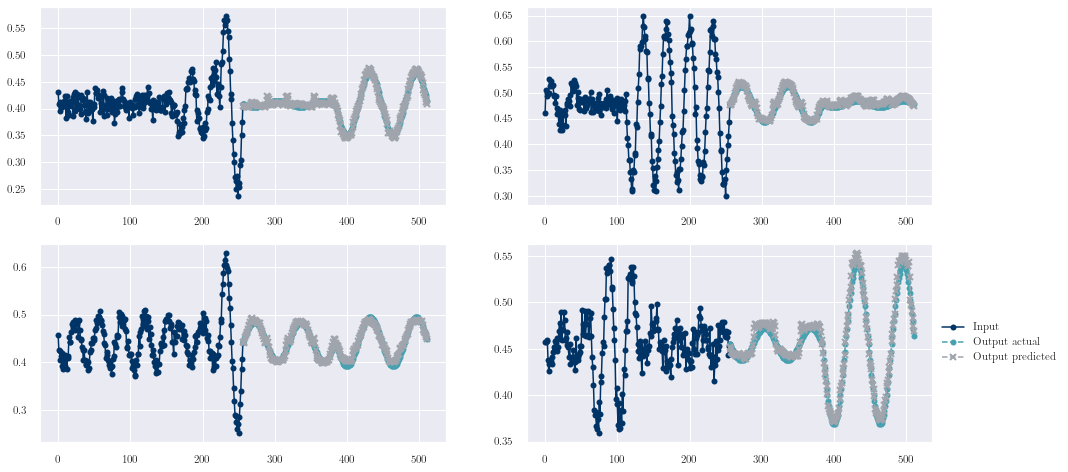

In [26]:
out_preds = []

for idx, model in zip(best_samples["sample_idx"], best_samples["model"]):
    out_preds.append(outputs[model][idx])

trafo_out_pred = cnn_outputs[best_samples["sample_idx"]]
# Visualize
use_latex_font = False
viz = ModelPredictionVisualization(use_latex_font=False)
viz.subplots(nrows=viz_num // 2, ncols=2, figsize=(16, 8))
viz.plot(best_x, best_y, out_preds, pred_starts=[pred_start, ] * viz_num)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
viz.save(filename=base_dir_notebook+ "/figures/worst_samples.pdf")
viz.plt.show()

# visualize by mean

2021-11-10 23:55:17 Mischa-PC src.visualization[8308] INFO using latex font


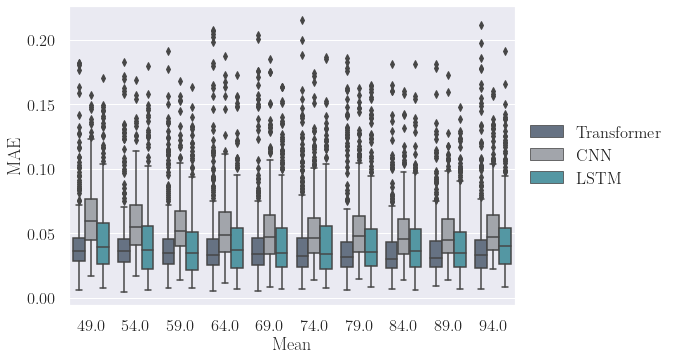

In [27]:
sorted(predictions["mean"].unique())

bin_boundaries = np.linspace(47, 97, 11)
bins = np.linspace(49, 94, 10)
for i in range(len(bin_boundaries) - 1):
    predictions.loc[(predictions["mean"] >= bin_boundaries[i]) & (predictions["mean"] < bin_boundaries[i + 1]), "mean_bin"] = bins[i]

viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axs = viz.subplots(1, 1)
sns.boxplot(x="mean_bin", y="mae", hue="model", data=predictions, palette=palette_bp)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
plt.ylabel("MAE")
plt.xlabel("Mean")
plt.savefig(base_dir_notebook + "/figures/mae_different_mean_bins.pdf", bbox_inches="tight")

## Analyze Generalization Capabilities by looking at missing train delay length
Not that interesting. Maybe beccause of the data. Model can learn the first amplitude from the first
highest value independant of delay length. The second one I am not so sure about...

2021-11-10 23:55:19 Mischa-PC src.visualization[8308] INFO using latex font


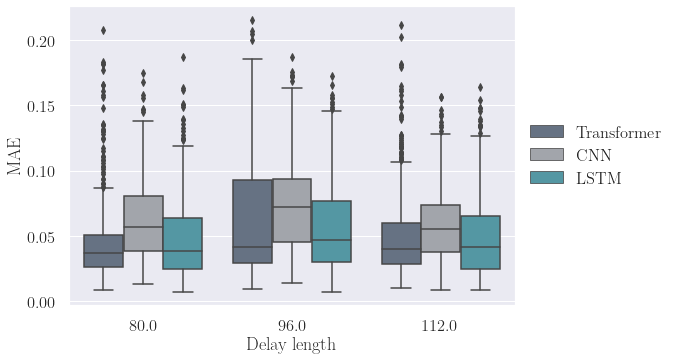

In [28]:
viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axs = viz.subplots(1, 1)
sns.boxplot(x="d", y="mae", hue="model", data=predictions[predictions["d"].isin([80, 96, 112])], palette=palette_bp)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model"
plt.ylabel("MAE")
plt.xlabel("Delay length")
plt.savefig(base_dir_notebook + "/figures/mae_different_delays_all_models_generalization_only.pdf")

# Analyzing Optuna Studies
## Visualize all model validation performances

2021-11-10 23:55:20 Mischa-PC src.visualization[8308] INFO using latex font
2021-11-10 23:55:20 Mischa-PC matplotlib.legend[8308] WARNING No handles with labels found to put in legend.


<Figure size 576x396 with 0 Axes>

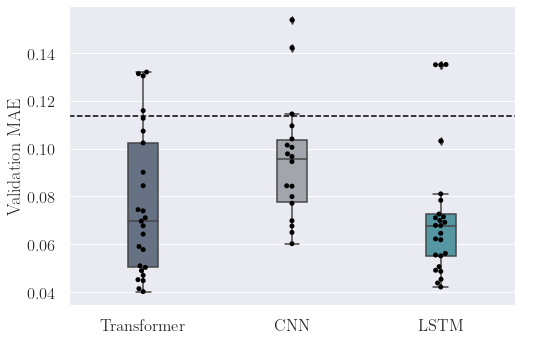

In [29]:
cnn_study_path = f"./models/{experiment_name}/cnn"
lstm_study_path = f"./models/{experiment_name}/lstm"
transformer_study_path= f"./models/{experiment_name}/transformer"

# load study summary (created by hyperparameter_tuning.py)
studies = {"cnn": cnn_study_path, "lstm": lstm_study_path, "transformer":transformer_study_path}
summaries = {}
models = {}
for model, path in studies.items():
    with open(os.path.join(path, "study_summary.yaml"), "r") as inp:
        try:
            summary = yaml.load(inp, Loader=yaml.BaseLoader)
        except yaml.YAMLError as e:
            print(e)
    summaries[model] = summary

# load optuna study from information contained in study_summary
MODEL_TO_MODEL_NAME = {"cnn": "CNN", "lstm":"LSTM", "transformer":"Transformer"}
train_values = []
for model in summaries.keys():
    storage = summaries[model]["storage_name"]
    study = optuna.load_study(study_name=summaries[model]["study_name"], storage=storage)
    for trial in study.trials:
        train_values.append({"train_value":trial.value, "model":MODEL_TO_MODEL_NAME[model]})


# train mae dataframe
train_values = pd.DataFrame(train_values)

plt.clf()
viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axs = viz.subplots(1, 1)
sns.boxplot(x="model", y="train_value", order=["Transformer", "CNN", "LSTM"], data=train_values, palette=palette_bp, width=0.2)
sns.swarmplot(x="model", y="train_value", order=["Transformer", "CNN", "LSTM"], data=train_values, color="0")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
viz.get_ax(0).axhline(mean_predictor_mae, c="black", ls='--')
plt.ylabel("Validation MAE")
plt.xlabel("")
plt.savefig(base_dir_notebook + "/figures/validation_all_trials.pdf")

## Training time visualization

2021-11-10 23:55:21 Mischa-PC src.visualization[8308] INFO using latex font


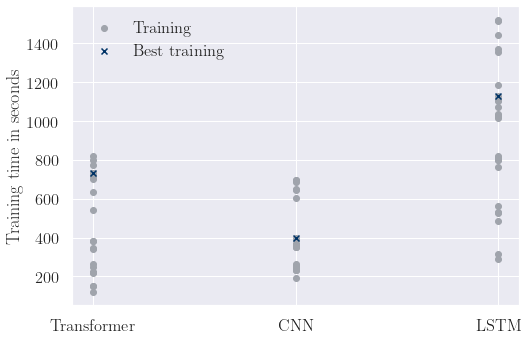

In [30]:
import optuna
from src.visualization.utils import FAU_BLUE, FAU_GREY

# load training time from optuna study
train_times = []
for model in ["transformer", "cnn", "lstm"]:
    storage = summaries[model]["storage_name"]
    study = optuna.load_study(study_name=summaries[model]["study_name"], storage=storage)
    for trial in study.trials:
        train_length = (trial.datetime_complete - trial.datetime_start).total_seconds()
        train_times.append({"train_length":train_length, "model":MODEL_TO_MODEL_NAME[model], "best":trial.number == study.best_trial.number})
train_times = pd.DataFrame(train_times)
best_times = train_times[train_times["best"] == True]

viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axs = viz.subplots(1, 1)
plt.scatter(train_times["model"], train_times["train_length"], color=FAU_GREY, marker='o', label="Training")
plt.scatter(best_times["model"], best_times["train_length"], color=FAU_BLUE, marker='x', label="Best training")
plt.ylabel("Training time in seconds")
plt.legend()
plt.savefig(base_dir_notebook + "/figures/training_times.pdf")

## Inference time visualization

2021-11-10 23:55:21 Mischa-PC src.data[8308] INFO Loading dataset from ./experiments/experiment_1_delay_length/data/test.pkl
2021-11-10 23:55:21 Mischa-PC src.visualization[8308] INFO using latex font
C:\Users\Mischa\Anaconda3\envs\mtenv\lib\site-packages\pytorch_lightning\trainer\trainer.py:678: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
2021-11-10 23:55:21 Mischa-PC pytorch_lightning.accelerators.gpu[8308] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Mischa\Anaconda3\envs\mtenv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

2021-11-10 23:55:22 Mischa-PC pytorch_lightning.accelerators.gpu[8308] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-10 23:55:23 Mischa-PC pytorch_lightning.accelerators.gpu[8308] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-10 23:55:23 Mischa-PC pytorch_lightning.accelerators.gpu[8308] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-10 23:55:24 Mischa-PC pytorch_lightning.accelerators.gpu[8308] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-10 23:55:24 Mischa-PC pytorch_lightning.accelerators.gpu[8308] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-10 23:55:26 Mischa-PC pytorch_lightning.accelerators.gpu[8308] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-10 23:55:27 Mischa-PC pytorch_lightning.accelerators.gpu[8308] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-10 23:55:28 Mischa-PC pytorch_lightning.accelerators.gpu[8308] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-10 23:55:29 Mischa-PC pytorch_lightning.accelerators.gpu[8308] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-10 23:55:30 Mischa-PC pytorch_lightning.accelerators.gpu[8308] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-10 23:55:32 Mischa-PC pytorch_lightning.accelerators.gpu[8308] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-10 23:55:34 Mischa-PC pytorch_lightning.accelerators.gpu[8308] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-10 23:55:36 Mischa-PC pytorch_lightning.accelerators.gpu[8308] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-10 23:55:38 Mischa-PC pytorch_lightning.accelerators.gpu[8308] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

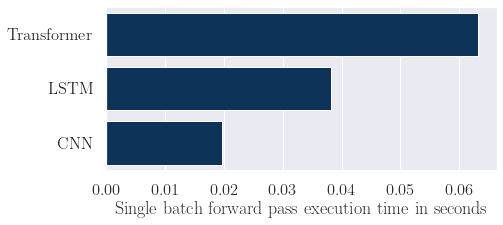

In [31]:
n_runs = 5
dataloader = DataLoader(SyntheticDataset.load(test_dataset_path),
                                 batch_size=128, drop_last=True) # drop incomplete batch
viz = InferenceTimeVisualization(use_latex_font=True, font_scale=1.5)
viz.do_inference(n_runs=n_runs,
                 cnn_model=trained_models["cnn"]["model"],
                 cnn_trainer=cnn_trainer,
                 lstm_model=trained_models["lstm"]["model"],
                 lstm_trainer=lstm_trainer,
                 trafo_model=trained_models["transformer"]["model"],
                 trafo_trainer=tf_trainer,
                 dataloader=dataloader)
fig, axs = viz.subplots(1, 1, figsize=(7, 3))
viz.plot(axs[0, 0], palette=[FAU_BLUE,])
axs[0,0].set_xlabel("Single batch forward pass execution time in seconds")
axs[0,0].set_ylabel("")
plt.savefig(base_dir_notebook + f"/figures/single_batch_exec_{n_runs}_runs.pdf")

## Statistical tests


### Critical Difference Test from Fawaz paper applied to dataset

In [32]:
# what characteristic to look at
critical_difference_parameter = "d"
mean_prediction_by_model = predictions.groupby(["model", critical_difference_parameter]).mean()
mean_prediction_by_model.head()
mean_prediction_by_model.reset_index(inplace=True) # resets multiindex
df_perf = mean_prediction_by_model[["model", critical_difference_parameter, "mae"]].rename(columns={"model":"classifier_name", critical_difference_parameter:"dataset_name", "mae":"accuracy"})

# reverse mae (for regression low values are good, for classification high values are good
df_perf["accuracy"] = df_perf["accuracy"].max() - df_perf["accuracy"]
df_perf.head(7)

,classifier_name,dataset_name,accuracy
0,CNN,0.0,0.023767
1,CNN,16.0,0.024295
2,CNN,32.0,0.026648
3,CNN,48.0,0.025233
4,CNN,64.0,0.015570
5,CNN,80.0,0.011157
6,CNN,96.0,0.000000


['CNN' 'LSTM' 'Transformer']
CNN            0.0
LSTM           3.0
Transformer    9.0
dtype: float64
CNN            3.00
LSTM           1.75
Transformer    1.25
dtype: float64
('CNN', 'LSTM', 0.00048828125, True)
('CNN', 'Transformer', 0.00048828125, True)
('LSTM', 'Transformer', 0.1513671875, False)
Index(['CNN', 'LSTM', 'Transformer'], dtype='object')
[1, 2]


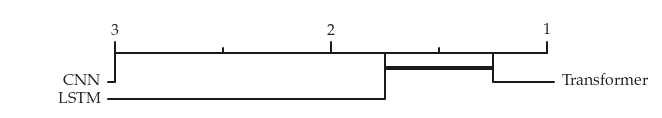

In [33]:
from src.visualization.critical_difference import draw_cd_diagram
draw_cd_diagram(df_perf=df_perf, output_path=os.path.join(base_dir_notebook, f"figures/critical_difference_test_for_{critical_difference_parameter}.pdf"))

### Critical difference test on all different characteristics

In [34]:
#pred_2 = predictions[predictions["d"].isin([0, 16, 32, 64, 128])]
mean_prediction_by_model = predictions.groupby(["model", "d", "l", "s", "f"]).mean()
mean_prediction_by_model.reset_index(inplace=True) # resets multiindex
mean_prediction_by_model.head()

,model,d,l,s,f,a1,a2,a3,mean,mae,mse,sample_idx,a1_bin,a2_bin,mean_bin
0,CNN,0.0,512.0,2.0,0.03125,-1.102102,0.717718,0.618619,70.099099,0.049975,0.004506,166.0,-0.525526,1.006006,70.261261
1,CNN,16.0,512.0,2.0,0.03125,-0.831832,-2.252252,-2.585586,73.021021,0.049448,0.004290,499.0,-0.195195,-1.546547,73.024024
2,CNN,32.0,512.0,2.0,0.03125,0.336336,-1.327327,-1.606607,71.567568,0.047094,0.003659,832.0,0.315315,-0.765766,71.672673
3,CNN,48.0,512.0,2.0,0.03125,-2.585586,-2.321321,-0.810811,71.291291,0.048509,0.003958,1165.0,-2.297297,-1.606607,71.342342
4,CNN,64.0,512.0,2.0,0.03125,2.888889,-1.969970,-0.726727,71.261261,0.058173,0.006777,1498.0,3.198198,-1.276276,71.222222


In [35]:
# rename to accomodate convection
df_perf = mean_prediction_by_model[["model", "d", "l", "s", "f", "mae"]].rename(columns={"model":"classifier_name", "mae":"accuracy"})
df_perf["dataset_name"] = ""

# populate dataset_names that indicates the different characteritics
dataset_names = []
for i in range(len(df_perf)):
    entry = df_perf.iloc[i]
    dataset_names.append(f"delay_{int(entry['d'])}_fre_{str(entry['f'])[2:]}_sigma_{int(entry['s'])}_len_{int(entry['l'])}")
df_perf["dataset_name"] = dataset_names
df_perf = df_perf[["classifier_name", "accuracy", "dataset_name"]]
df_perf.head(3)

,classifier_name,accuracy,dataset_name
0,CNN,0.049975,delay_0_fre_03125_sigma_2_len_512
1,CNN,0.049448,delay_16_fre_03125_sigma_2_len_512
2,CNN,0.047094,delay_32_fre_03125_sigma_2_len_512


['CNN' 'LSTM' 'Transformer']
CNN            0.0
LSTM           3.0
Transformer    9.0
dtype: float64
CNN            3.00
LSTM           1.75
Transformer    1.25
dtype: float64
('CNN', 'LSTM', 0.00048828125, True)
('CNN', 'Transformer', 0.00048828125, True)
('LSTM', 'Transformer', 0.1513671875, False)
Index(['CNN', 'LSTM', 'Transformer'], dtype='object')
[1, 2]


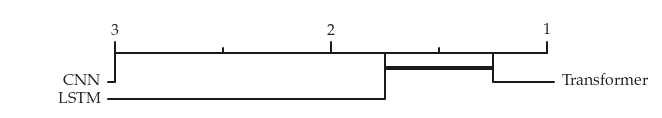

In [36]:
# reverse mae (for regression low values are good, for classification high values are good
df_perf["accuracy"] = df_perf["accuracy"].max() - df_perf["accuracy"]
df_perf.head(7)
from src.visualization.critical_difference import draw_cd_diagram
draw_cd_diagram(df_perf=df_perf, output_path=os.path.join(base_dir_notebook, f"figures/critical_difference_test_for_all_parameters.pdf"))


